<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Collaborative Filtering based Recommender System using Non-negative Matrix Factorization**


Estimated time needed: **60** minutes


In the previous lab, we have performed KNN on user-item interaction matrix to estimate the rating of unknown items based on the aggregation of the user's K nearest neighbor's ratings. Finding nearest neighbors are based on similarity measurements among users or items with big similarity matrices. 


The KNN algorithm is memory-based which means we need to keep all instances for prediction and maintain a big similarity matrix. These can be infeasible if our user/item scale is large, for example, 1 million users will require a 1 million by 1 million similarity matrix, which is very hard to load into RAM for most computation environments.


#### Non-negative matrix factorization


In the machine learning course, you have learned a dimensionality reduction algorithm called Non-negative matrix factorization (NMF), which decomposes a big sparse matrix into two smaller and dense matrices.

Non-negative matrix factorization can be one solution to big matrix issues. The main idea is to decompose the big and sparse user-interaction into two smaller dense matrices, one represents the transformed user features and another represents the transformed item features.


An example is shown below, suppose we have a user-item interaction matrix $A$ with 10000 users and 100 items (10000 x 100), and its element `(j, k)` represents the rating of item `k` from user `j`. Then we could decompose $A$ into two smaller and dense matrices $U$ (10000 x 16) and $I$ (16 x 100). for user matrix $U$, each row vector is a transformed latent feature vector of a user, and for the item matrix $I$, each column is a transformed latent feature vector of an item. 

Here the dimension 16 is a hyperparameter defines the size of the hidden user and item features, which means now the shape of transposed user feature vector and item feature vector is now 16 x 1.


The magic here is when we multiply the row `j` of $U$ and column `k` of matrix $I$, we can get an estimation to the original rating $\hat{r}_{jk}$. 

For example, if we preform the dot product user ones  row vector in $U$ and item ones  column vector in $I$, we can get the rating estimation of user one to item one, which is the element (1, 1) in the original interaction matrix $I$. This r


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


Note $I$ is short for Items, and it is not an identity matrix.


Then how do we figure out the values in $U$ and $I$ exactly? Like many other machine learning processes, we could start by initializing the values of $U$ and $I$, then define the following distance or cost function to be minimized:


$$\sum_{r_{jk} \in {train}} \left(r_{jk} - \hat{r}_{jk} \right)^2,$$


where $\hat{r}_{ij}$ is the dot product of $u_j^T$ and $i_k$:


$$\hat{r}_{jk} = u_j^Ti_k$$


The cost function can be optimized using stochastic gradient descent (SGD) or other optimization algorithms, just like in training the weights in a logistic regression model (there are several additional steps so the matrices have no negative elements) . 


## Objectives


After completing this lab you will be able to:


* Perform NMF-based collaborative filtering on the user-item matrix


----


### Load and exploring dataset


Let's first load our dataset, i.e., the user-item (learn-course) interaction matrix


In [3]:
import pandas as pd
from surprise.model_selection import GridSearchCV
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_url = "nice_data.csv"

rating_df = pd.read_csv(rating_url)

In [5]:
rating_df.head()

,user,item,rating
0,2,BD0221EN,3.0
1,2,LB0107ENv1,3.0
2,2,SC0105EN,2.0
3,2,CO0201EN,0.0
4,2,BD0123EN,2.0


The dataset contains three columns, `user id`, `item id`, and `the rating`. Note that this matrix is presented as the dense or vertical form, you may convert it using `pivot` to the original sparse matrix:


In [6]:
rating_sparse_df = rating_df.pivot(index='user', columns='item', values='rating').fillna(0).reset_index().rename_axis(index=None, columns=None)
rating_sparse_df.head()

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,3.0,0.0,0.0,3.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,3.0,0.0,2.0,2.0,0.0,3.0,0.0
1,4,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0
2,5,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, you need to implement NMF-based collaborative filtering, and you may choose one of the two following implementation options: 
- The first one is to use `Surprise` which is a popular and easy-to-use Python recommendation system library. 
- The second way is to implement it with `numpy`, `pandas`, and `sklearn`. You may need to write a lot of low-level implementation code along the way.


## Implementation Option 1: Use **Surprise** library (recommended)


*Surprise* is a Python scikit library for recommender systems. It is simple and comprehensive to build and test different recommendation algorithms. First let's install it:


In [7]:
# !pip install scikit-surprise==1.1.1

We import required classes and methods


In [8]:
from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [21]:
rating_df["rating"] += 1
rating_df.to_csv("course_ratings.csv", index=False)
# Read the course rating dataset with columns user item rating
reader = Reader(
        line_format='user item rating', sep=',', skip_lines=1, rating_scale=(1, 4))

coruse_dataset = Dataset.load_from_file("course_ratings.csv", reader=reader)

Now  we split the data into a train-set and test-set:


In [22]:
trainset, testset = train_test_split(coruse_dataset, test_size=.3)

Then check how many users and items we can use to fit the KNN model:


In [23]:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the trainingset")

Total 33899 users and 126 items in the trainingset


### TASK: Perform NMF-based collaborative filtering on the course-interaction matrix


_TODO: Fit a NMF model using the trainset and evaluate the results using the testset_ The code will be very similar to the KNN-based collaborative filtering, you just need to use the `NMF()` model.


In [24]:
nmf = NMF(verbose=True, random_state=123)

nmf.fit(trainset)
predictions = nmf.test(testset)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


In [25]:
# Then compute RMSE
acc = accuracy.rmse(predictions)    


RMSE: 1.0785


In [26]:
## WRITE YOUR CODE HERE:


# - Define a NMF model NMF(verbose=True, random_state=123)

# - Train the NMF on the trainset, and predict ratings for the testset

# - Then compute RMSE

# more NMF model hyperparamets can be found here:

# https://surprise.readthedocs.io/en/stable/matrix_factorization.html

# You may try different hyperparamet combinations to see which one has the best performance

ns = np.array( [5,8,10,12,15,20,30,40,50] )
rmses = []
for n in ns:
    nmf = NMF(n_factors=n,verbose=True, random_state=123)

    nmf.fit(trainset)
    predictions = nmf.test(testset)
    rmses.append( accuracy.rmse(predictions)   )

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 1.08

Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 1.0036


In [28]:
ns1 = np.array( [70,100,200] )
for n in ns1:
    nmf = NMF(n_factors=n,verbose=True, random_state=123)

    nmf.fit(trainset)
    predictions = nmf.test(testset)
    rmses.append( accuracy.rmse(predictions)   )

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.99

In [30]:
ns2 = np.array( [150,250,300] )
for n in ns2:
    nmf = NMF(n_factors=n,verbose=True, random_state=123)

    nmf.fit(trainset)
    predictions = nmf.test(testset)
    rmses.append( accuracy.rmse(predictions)   )

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.96

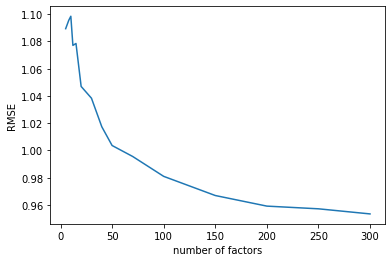

In [34]:
nns = np.array( list(ns)+list(ns1)+list(ns2) )
armses = np.array(rmses)
p = np.argsort(nns)

plt.plot(nns[p], armses[p])
plt.xlabel("number of factors")
plt.ylabel("RMSE")

plt.savefig("NMF_nfac.png")


In [35]:
nmf = NMF(n_factors=150,verbose=True, random_state=123)

nmf.fit(trainset)
predictions = nmf.test(testset)
accuracy.rmse(predictions)   

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.96

0.9669193053336655

In [36]:
predictions = nmf.test(testset)
dummy = []
for i in range( len(predictions) ):     
    dummy.append( predictions[i].est )
    
min(dummy) , max(dummy)

(1, 4)

<details>
    <summary>Click here for Hints</summary>

* Create a model by calling `NMF()` class and set parameters to `init_low=0.5, init_high = 5.0, n_factors=32`. 
* Fit it  with `trainset` by using `model.fit(trainset)`.  
* Record predictions to the `testset`  by using `model.test(testset).
* Compute the accuracy by using `accuracy.rmse(predictions)`


To learn more detailed usages about _Surprise_ library, visit its website from [here](https://surprise.readthedocs.io/en/stable/getting_started.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01)


## Implementation Option 2: Use `numpy`, `pandas`, and `sklearn`.


If you do not prefer the one-stop Suprise solution, you may implement the KNN model using `numpy`, `pandas`, and possibly `sklearn`:


In [11]:
## WRITE YOUR CODE HERE:

## One solution could be:

## - Use the NMF() class provided by sklearn to decompose the original user-item interaction matrix

## - For each rating in the test dataset, estimate its rating using the dot product of matrix U and matrix I, following the previous equation

## - Calculate the RMSE for the entire test dataset


## Summary


In this lab, you have learned and practiced NMF-based collaborative filtering. The basic idea is to decompose the original user-item interaction matrix into two smaller and dense user and item matrices. Then, we have built the two matrices, we can easily estimate the unknown ratings via the dot product of specific row in user matrix and specific column in item matrix.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01)


### Other Contributors


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-10-25|1.0|Yan|Created the initial version|


Copyright © 2022 IBM Corporation. All rights reserved.
